# Lesson 7: Decisions

## Intro to Quantified Cognition

By: Per B. Sederberg, PhD


<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2021_Spring/notebooks/07_Decisions.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>



## Lesson plan

- Intro to cognitive models
- Pivot to decision-making models
- Exploration of decision-making data
- Linear Ballistic Accumulator exploration
- Model fits to data


## The Mind as a Black Box

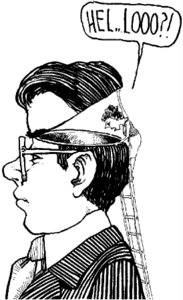

- Stuff comes in, behaviors come out...
- But what's going on in the box?

![](http://25.media.tumblr.com/tumblr_ljpq2nYt9D1qzgjfco1_500.gif)

## It's all RAD

### ***Representations***
### ***Associations***
### ***Dynamics***

## Decisions as an important and accessible cognitive process

- Although we could try and open the box for all sorts of cognitive behaviors (e.g., perception, memory, etc...), decision making is a pervasive aspect of our lives.

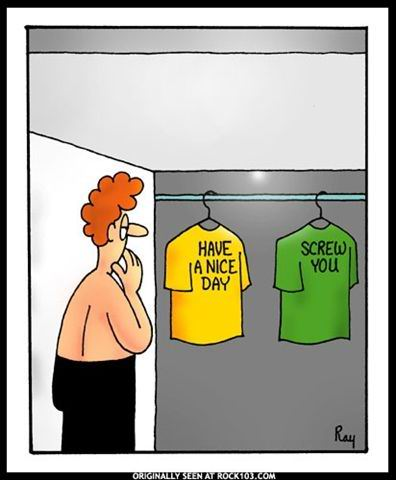

- What are some examples of decisions we make?


## How do we study decisions?

- What food would you rather eat?
- What direction are these dots moving?

## Questions we ask about decisions

- What choice did you make?
- How quickly did you make it?

## Example: Speed--Accuracy trade-off

- Sometimes we have to make fast decisions
- Other times we just need to be as accurate as possible.

## *ONLY* if on Google Colab

In [1]:
# to install RunDEMC
!pip install fastprogress
!pip install git+https://github.com/compmem/RunDEMC.git


  Cloning https://github.com/compmem/RunDEMC.git to /tmp/pip-req-build-vy6znyej
  Running command git clone -q https://github.com/compmem/RunDEMC.git /tmp/pip-req-build-vy6znyej
  Created wheel for RunDEMC: filename=RunDEMC-0.1.0-py3-none-any.whl size=47262 sha256=db6ec4af20529454a116d1d5905c8bdef0da66733d5fd5924d7a963ecbcad5b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-6eqdrs6x/wheels/79/3a/34/0f720f2600b6465d20f6d89bdfe546c94d87a0074d5e687312
Successfully built RunDEMC
  Attempting uninstall: RunDEMC
    Found existing installation: RunDEMC 0.1.0
    Uninstalling RunDEMC-0.1.0:
      Successfully uninstalled RunDEMC-0.1.0


In [2]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/2021_Spring/notebooks/decision_data.csv

--2021-03-18 12:22:02--  https://raw.githubusercontent.com/compmem/QuantCog/2021_Spring/notebooks/decision_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-03-18 12:22:02 ERROR 404: Not Found.



In [3]:
# to install plotnine (and fix statsmodels on Colab)
!pip install plotnine
!pip install KDEpy
!pip install arviz
#!pip install statsmodels -U

## Load modules

In [4]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats
import plotnine as pn
import arviz as az

from ipywidgets import interact, fixed

from RunDEMC.density import kdensity
from KDEpy import FFTKDE

## Load and process the data

In [5]:
# load in the data
dat = pd.read_csv('decision_data.csv', index_col=0)

# get rid of the neutral condition
dat = dat[dat.cond != 'Neutral']

# make a new column that combines accuracy and rt
dat['rt_acc'] = dat['rt']
dat.loc[dat.correct==0,'rt_acc'] = -dat['rt']
dat.head()

,correct,rt,cond,log_rt,rt_acc
3,1,0.4784,Accuracy,-0.737308,0.4784
4,1,0.4300,Accuracy,-0.843970,0.4300
5,1,0.4486,Accuracy,-0.801624,0.4486
6,1,0.3991,Speed,-0.918543,0.3991
8,1,0.4393,Accuracy,-0.822573,0.4393


/home/per/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


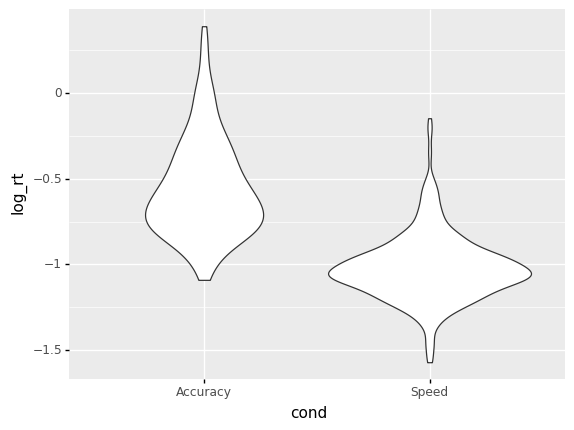

<ggplot: (8781604435069)>

In [6]:
# plot the RTs for the two conditions
(pn.ggplot(dat, pn.aes('cond', 'log_rt'))
 + pn.geom_violin())

/home/per/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


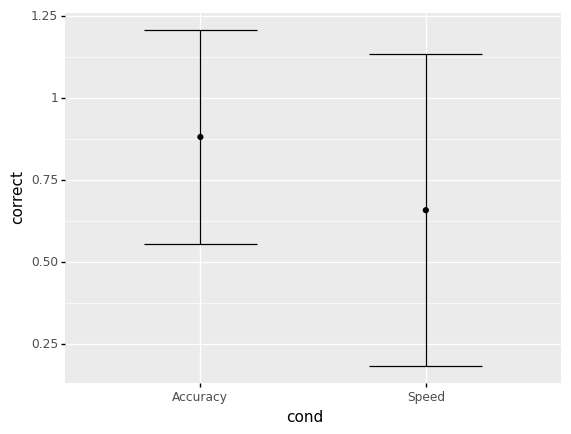

<ggplot: (8781604435101)>

In [7]:
# plot the accuracy for the two conditions
(pn.ggplot(dat, pn.aes('cond', 'correct'))
 + pn.stat_summary(fun_y=np.mean, geom='point')
 + pn.stat_summary(fun_data = 'mean_sdl', fun_args = {'mult':1}, geom = 'errorbar'))

In [8]:
# show trade-off between speed and accuracy
df = dat.groupby(['cond'])[['log_rt','correct']].mean().reset_index()
df

,cond,log_rt,correct
0,Accuracy,-0.552049,0.880109
1,Speed,-1.017115,0.657068


In [9]:
dat.groupby(['cond', 'correct'])['rt'].mean().reset_index()


,cond,correct,rt
0,Accuracy,0,0.589848
1,Accuracy,1,0.603819
2,Speed,0,0.349665
3,Speed,1,0.379169


## What does this tell us?

- Looking at behavioral effects alone can not reveal the processes that gave rise to that choice and RT.

- i.e., if you made a specific response, we don't know *why* you made that response.

## Going Deeper: What affects your decisions? 


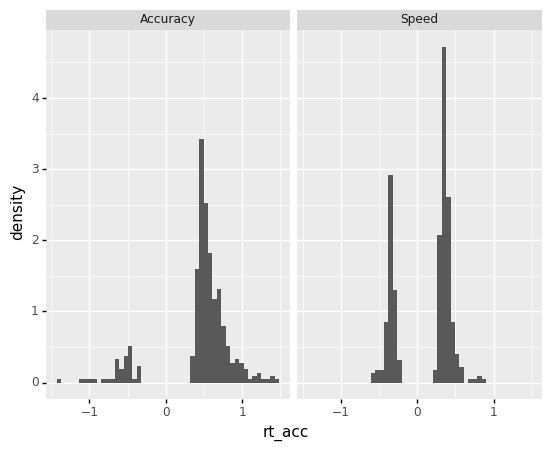

<ggplot: (8781603797717)>

In [10]:
# Plot the reaction time distributions
(pn.ggplot(dat, pn.aes('rt_acc')) + pn.geom_histogram(pn.aes(y='..density..'), bins=50) 
 + pn.facet_wrap('~cond'))

## What is a computational model? 

- Take processes and instantiate them within a set of equations with explicit rules for how they interact.

## Linear Ballistic Accumlator (LBA)

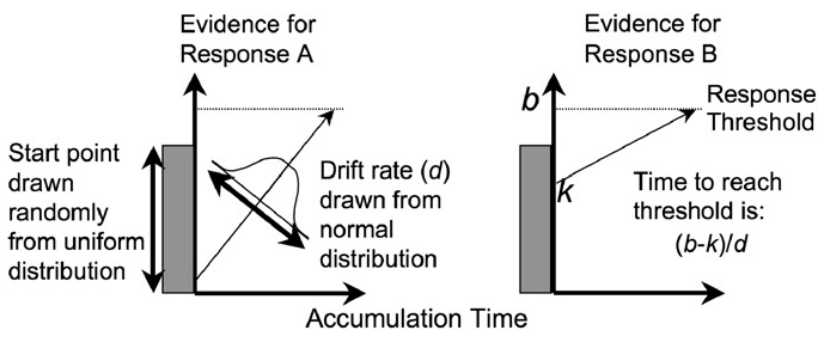

In [11]:
def lba_sim(I=(1.0,1.5), A=.1, S=1.0, b=1.0, num_sims=1000,
            max_time=2., t0=0.0, **kwargs):
    # set drift rate from inputs
    dr = np.float64(I)
    
    # set the number of choices
    nc = len(dr)
    
    # pick starting points
    k = np.random.uniform(0.,A,(num_sims,nc))
    
    # pick drifts
    # must make sure at least one d is greater than zero for each sim
    d = np.random.normal(dr,S,(num_sims,nc))
    # see where there are none above zero
    ind = np.all(d<=0.0,axis=1)
    while np.any(ind):
        d[ind,:] = np.random.normal(dr,S,(ind.sum(),nc))
        ind = np.all(d<=0.0,axis=1)

    # clip it to avoid divide by zeros
    d[d<=0.0] = np.finfo(dr.dtype).eps

    # calc the times for each
    t = (b-k)/d

    # see the earliest for each resp
    inds = t.argmin(1)
    times = t.take(inds+np.arange(t.shape[0])*t.shape[1])

    # process into choices
    times += t0

    # get valid responses
    resp_ind = times < (max_time)
    rts = []
    for i in range(nc):
        rt = times[resp_ind & (inds==i)]
        rts.append(rt)

    return rts



In [12]:
# set up the sim
nsims = 5000
cond='Accuracy'
ndat = (dat['cond']==cond).sum()
plt.figure(figsize=(10,6))

# normed histogram
def dhist(dat, nsims, alpha=.3, color='b'):
    p,b = np.histogram(dat,bins='auto',density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nsims
    return plt.bar(b[1:]-w,p,width=w,alpha=.3,color=color)

# normed pdf
xvals = np.linspace(0.1,2.0,100)
def dplot(dat, nsims, color='b', lw=2.):
    p,xx = kdensity(dat, extrema=(xvals.min(),xvals.max()), xx=xvals)
    #p = FFTKDE(kernel='epa', bw='silverman').fit(dat).evaluate(xvals)
    p *= float(len(dat))/nsims
    plt.plot(xvals, p, color=color, lw=2.)

# put it all together
@interact(d1=(0.0,5.0,0.05),
          d2=(0.0,5.0,0.05),
          A=(0.0,1.0,.05),
          b=(0.0,5.0,.05),
          t0=(0.0,1.0,.02),
          S=fixed(1.0)
          )
def run_lba(d1=1.0, d2=2.0, A=.1, b=1.0, t0=0.0, S=1.0):
    # run the LBA model
    res = lba_sim(I=(d1, d2), A=A, S=S, b=b, num_sims=nsims, max_time=2.0, t0=t0)
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    dplot(res[1], nsims, color='b')
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    dplot(res[0], nsims, color='r')
    #ylim(0,5.0)
    plt.xlim(0,2.0)

<Figure size 720x432 with 0 Axes>

interactive(children=(FloatSlider(value=1.0, description='d1', max=5.0, step=0.05), FloatSlider(value=2.0, des…

## Differential Evolution

- Instead of random proposals for each new generation, bases proposals on the entire population:

![](https://upload.wikimedia.org/wikipedia/commons/e/e0/Ackley.gif)

## Using computers to test hypotheses

In [13]:
from RunDEMC import Model, Param, dists
#from RunDEMC.io import arviz_dict
from RunDEMC.de import DE

In [14]:
# define a likelihood function that evaluates an entire proposed population
def like_fun(pop, *args):
    # evaluate the model given the params
    # in this case the params are the points where we're evaluating the model
    return np.log(dists.normal(-.5, 0.5).pdf(pop)).sum(1)

# set up the model
params = [Param(name='mu', prior=dists.normal(0, 2.0))]
m = Model('test', params=params,
          like_fun=like_fun,
          pop_recarray=False,
          verbose=True)

# run the model, first with some burnin
times = m.sample(100, burnin=True)
times = m.sample(600, burnin=False)

Initializing: 10(10) Iterations (100):


Iterations (600):


In [15]:
# convert to InferenceData for ArviZ
burnin=200
daz = az.from_dict(posterior={'theta':m.particles[burnin:,:,0].T}, 
                   sample_stats={'log_likelihood':m.weights[burnin:].T,
                                 'times': m.times[burnin:].T,
                                },
                   #log_likelihood=m.weights, 
                   prior={'log_prior':(m.weights-m.log_likes)[burnin:].T}
                   )

In [16]:
daz.posterior

<xarray.Dataset>
Dimensions:  (chain: 10, draw: 501)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
Data variables:
    theta    (chain, draw) float64 -0.4869 -0.4869 -0.4869 ... -0.2586 -0.2586
Attributes:
    created_at:     2021-03-18T16:22:11.232571
    arviz_version:  0.10.0

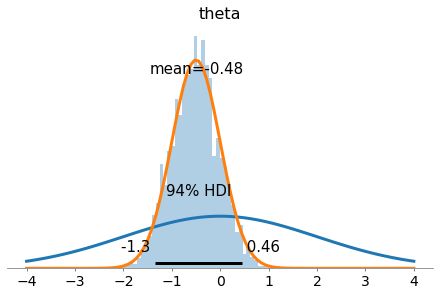

In [17]:
az.plot_posterior(daz, kind='hist', density=True)
x = np.linspace(-4,4,100)
plt.plot(x, params[0].prior.pdf(x), '-', lw=3)
plt.plot(x, dists.normal(-.5, 0.5).pdf(x), '-', lw=3)

In [18]:
az.summary(daz)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,-0.478,0.489,-1.346,0.459,0.014,0.01,1226.0,1182.0,1230.0,1088.0,1.01


## Quick t-test example with RunDEMC

Ttest_1sampResult(statistic=3.8928380057902903, pvalue=0.000690479163692217)

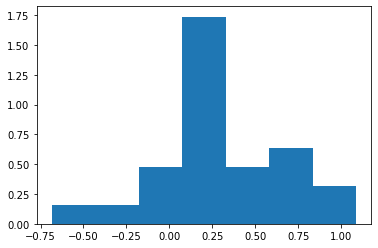

In [19]:
# generate some data that may or may not be significantly different from zero
A = dists.normal(.3, .5).rvs(25)

# plot it
plt.hist(A, bins='auto', density=True);

# do a one-sample t-test
import scipy.stats as stats

stats.ttest_1samp(A, 0.0)

In [20]:

# Define a likelihood function
def students_like(pop, *args):
    # pull the dat out of the args
    dat = args[0]
    
    # fix degrees of freedom
    df = len(dat) - 1
    
    # instantiate the model with the params, 
    # the df is determined from the data
    dist = dists.students_t(pop['mu'][:, np.newaxis], pop['sigma'][:, np.newaxis], df)
    
    # calc the log like and sum across items
    log_like = np.log(dist.pdf(dat)).sum(1)
    log_like[np.isnan(log_like)] = -np.inf
    
    # return the log like for each proposal
    return log_like

# set up the model
params = [Param(name='mu', prior=dists.normal(A.mean(), A.std()*2.0)),
          Param(name='sigma', prior=dists.halfcauchy(5))]

# set up DE
prop_gen = DE(gamma=(.4, 1.0), gamma_best=0.0, rand_base=False)
burnin_prop_gen = DE(gamma=(.4, 1.0), gamma_best=None, rand_base=True)

m = Model('t-test', params=params,
          like_fun=students_like,
          like_args=(A,),
          proposal_gen=prop_gen,
          burnin_proposal_gen=burnin_prop_gen,
          verbose=True)

# run the model, first with some burnin
times = m.sample(100, burnin=True)
times = m.sample(900, burnin=False)

Initializing: 20(20) Iterations (100):


Iterations (900):


In [21]:
# convert to InferenceData for ArviZ
burnin=400
daz = az.from_dict(posterior={m.param_names[i]: m.particles[burnin:,:,i].T 
                              for i in range(len(m.param_names))}, 
                   sample_stats={'log_likelihood':m.weights[burnin:].T,
                                 'times': m.times[burnin:].T,
                                },
                   #log_likelihood=m.weights, 
                   prior={'log_prior':(m.weights-m.log_likes)[burnin:].T}
                   )

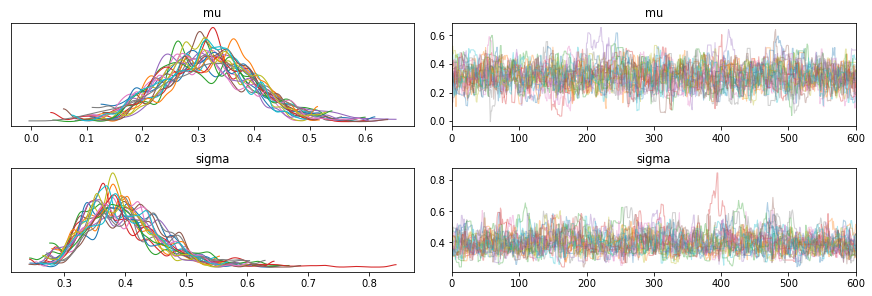

In [22]:
# check our trace
az.plot_trace(daz);

<AxesSubplot:title={'center':'mu'}>

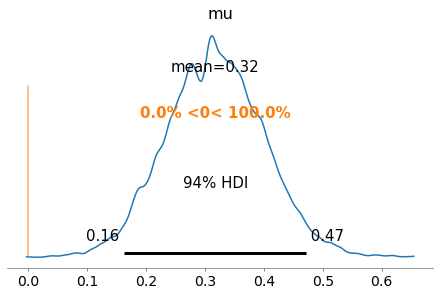

In [23]:
# plot the posterior of the mean
az.plot_posterior(daz, var_names=['mu'], ref_val=0.0)

In [24]:
az.summary(daz)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.317,0.083,0.163,0.472,0.002,0.002,1128.0,1088.0,1139.0,1500.0,1.02
sigma,0.399,0.064,0.290,0.523,0.002,0.001,1116.0,1073.0,1184.0,1480.0,1.02


/home/per/anaconda3/lib/python3.7/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
/home/per/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


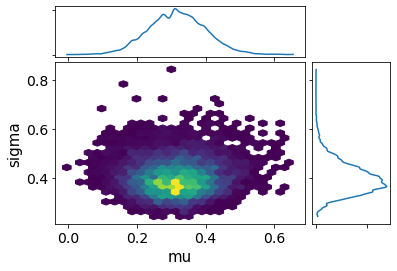

In [25]:
#az.plot_joint(daz, joint_kwargs={'alpha':.05});
az.plot_joint(daz, kind='hexbin');

## Fitting Decision Models

What do we do when our model doesn't have an analytical likelihood function?

PDA to the rescue!!!

In [26]:
# Test change in threshold

# set up the params
params = [Param(name='d1', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='b_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.trunc_normal(.2, 1.0, 0., 1.0))]

# grab the beh data of interest
dat_A_1 = np.array(dat[(dat['cond']=='Accuracy')&(dat['correct']==0)]['rt'])
dat_A_2 = np.array(dat[(dat['cond']=='Accuracy')&(dat['correct']==1)]['rt'])
num_A = float((dat['cond']=='Accuracy').sum())
prop_A_1 = len(dat_A_1)/num_A
prop_A_2 = len(dat_A_2)/num_A
dat_S_1 = np.array(dat[(dat['cond']=='Speed')&(dat['correct']==0)]['rt'])
dat_S_2 = np.array(dat[(dat['cond']=='Speed')&(dat['correct']==1)]['rt'])
num_S = float((dat['cond']=='Speed').sum())
prop_S_1 = len(dat_S_1)/num_S
prop_S_2 = len(dat_S_2)/num_S

# define the likelihood function
nsims = 10000
xvals = np.linspace(0, 2.0, 2000)
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first check for simple issues
        if (p['A'] > p['b_A']) or (p['A'] > p['b_S']) or \
           np.any(np.array(p.tolist())<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        res = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=1.0, b=p['b_A'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        
        # process first response
        if len(res[0])>2:
            #pp,xx = kdensity(res[0], extrema=(0,2.0), xx=dat_A_1)
            pp = np.interp(dat_A_1, xvals,
                           FFTKDE(kernel='epa', bw='silverman').fit(res[0]).evaluate(xvals))
            pp *= float(len(res[0]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # process second response
        if len(res[1])>2:
            #pp,xx = kdensity(res[1], extrema=(0,2.0), xx=dat_A_2)
            pp = np.interp(dat_A_2, xvals,
                           FFTKDE(kernel='epa', bw='silverman').fit(res[1]).evaluate(xvals))
            pp *= float(len(res[1]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # then Speed
        res = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=1.0, b=p['b_S'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        
        # process first response
        if len(res[0])>2:
            #pp,xx = kdensity(res[0], extrema=(0,2.0), xx=dat_S_1)
            pp = np.interp(dat_S_1, xvals,
                           FFTKDE(kernel='epa', bw='silverman').fit(res[0]).evaluate(xvals))
            pp *= float(len(res[0]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # process second response
        if len(res[1])>2:
            #pp,xx = kdensity(res[1], extrema=(0,2.0), xx=dat_S_2)
            pp = np.interp(dat_S_2, xvals,
                           FFTKDE(kernel='epa', bw='silverman').fit(res[1]).evaluate(xvals))
            pp *= float(len(res[1]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue

    return likes
        
# make the model
m = Model('decisions', params=params,
          like_fun=like_fun,
          like_args=(dat,),
          purify_every=5,
          verbose=True)


In [27]:
# do some burnin
times = m.sample(50, burnin=True)

Initializing: 60(60) 13(13) 3(3) 1(1) 1(1) 1(1) Iterations (50):


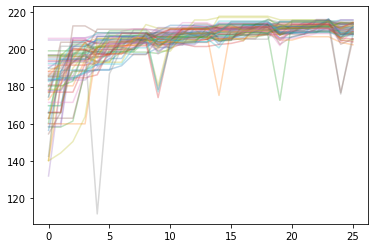

In [28]:
plt.plot(m.weights[25:], alpha=.3);

In [29]:
print("Best fitting params:")
burnin=5
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights.ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: 201.137960750409
"d1": 1.543520,
"d2": 2.574984,
"A": 0.396009,
"b_A": 1.275730,
"b_S": 0.721040,
"t0": 0.166188,


/home/per/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


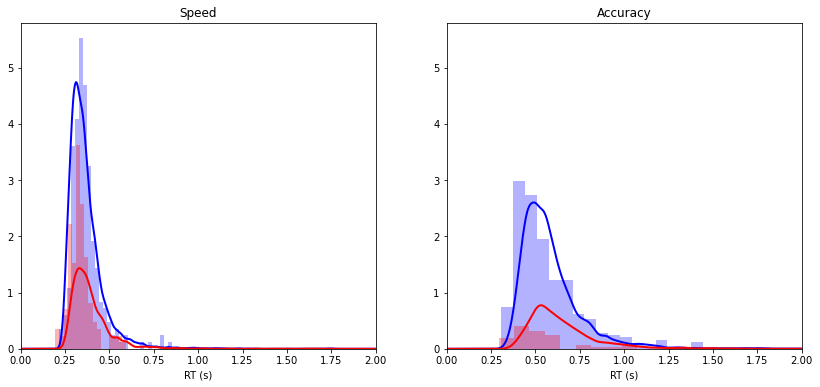

In [30]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(res[1], nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(res[0], nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(res[1], nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(res[0], nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);

In [31]:
# Test change in drift rate

# set up the params
params = [Param(name='d1_A', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2_A', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d1_S', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2_S', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.trunc_normal(.2, 1.0, 0., 1.0))]

# grab the beh data of interest
dat_A_1 = np.array(dat[(dat['cond']=='Accuracy')&(dat['correct']==0)]['rt'])
dat_A_2 = np.array(dat[(dat['cond']=='Accuracy')&(dat['correct']==1)]['rt'])
num_A = float((dat['cond']=='Accuracy').sum())
prop_A_1 = len(dat_A_1)/num_A
prop_A_2 = len(dat_A_2)/num_A
dat_S_1 = np.array(dat[(dat['cond']=='Speed')&(dat['correct']==0)]['rt'])
dat_S_2 = np.array(dat[(dat['cond']=='Speed')&(dat['correct']==1)]['rt'])
num_S = float((dat['cond']=='Speed').sum())
prop_S_1 = len(dat_S_1)/num_S
prop_S_2 = len(dat_S_2)/num_S

# set up the likelihood function
nsims = 10000
xvals = np.linspace(0, 2.0, 2000)
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first check for simple issues
        if (p['A'] > p['b']) or np.any(np.array(p.tolist())<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        res = lba_sim(I=(p['d1_A'], p['d2_A']), A=p['A'], S=1.0, b=p['b'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        
        # process first response
        if len(res[0])>2:
            #pp,xx = kdensity(res[0], extrema=(0,2.0), xx=dat_A_1)
            pp = np.interp(dat_A_1, xvals,
                           FFTKDE(kernel='epa', bw='silverman').fit(res[0]).evaluate(xvals))
            pp *= float(len(res[0]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # process second response
        if len(res[1])>2:
            #pp,xx = kdensity(res[1], extrema=(0,2.0), xx=dat_A_2)
            pp = np.interp(dat_A_2, xvals,
                           FFTKDE(kernel='epa', bw='silverman').fit(res[1]).evaluate(xvals))
            pp *= float(len(res[1]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # then Speed
        res = lba_sim(I=(p['d1_S'], p['d2_S']), A=p['A'], S=1.0, b=p['b'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])

        # process first response
        if len(res[0])>2:
            #pp,xx = kdensity(res[0], extrema=(0,2.0), xx=dat_S_1)
            pp = np.interp(dat_S_1, xvals,
                           FFTKDE(kernel='epa', bw='silverman').fit(res[0]).evaluate(xvals))
            pp *= float(len(res[0]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # process second response
        if len(res[1])>2:
            #pp,xx = kdensity(res[1], extrema=(0,2.0), xx=dat_S_2)
            pp = np.interp(dat_S_2, xvals,
                           FFTKDE(kernel='epa', bw='silverman').fit(res[1]).evaluate(xvals))
            pp *= float(len(res[1]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue

    return likes
        
# make the model
m = Model('decisions2', params=params,
          like_fun=like_fun,
          like_args=(dat,),
          purify_every=5,
          pop_parallel=True,
          verbose=True)


In [32]:
# do some burnin
times = m.sample(50, burnin=True)

Initializing: 70(70) 17(17) 3(3) Iterations (50):


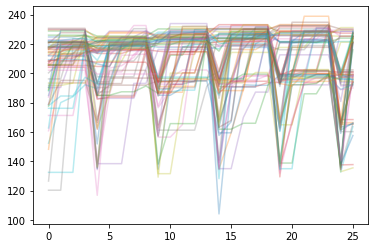

In [33]:
plt.plot(m.weights[25:], alpha=.3);

In [34]:
print("Best fitting params:")
burnin=5
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights.ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: 223.16074854133046
"d1_A": 1.444004,
"d2_A": 2.822063,
"d1_S": 3.891803,
"d2_S": 4.315216,
"A": 0.154267,
"b": 1.620049,
"t0": 0.027846,


/home/per/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


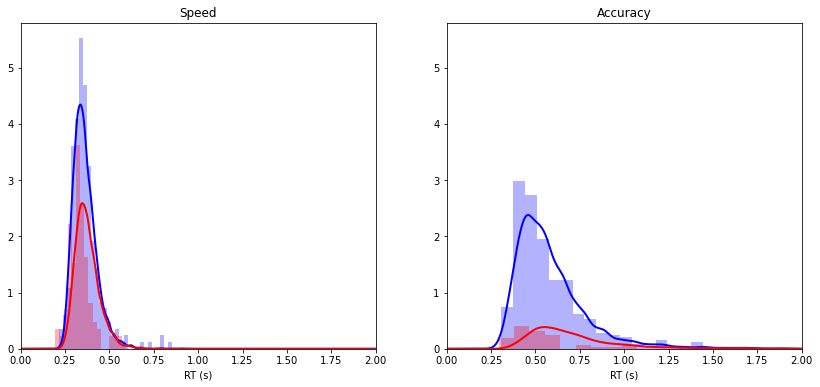

In [35]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1_'+cond[0]], pp['d2_'+cond[0]]), A=pp['A'], S=1.0, b=pp['b'], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(res[1], nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(res[0], nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1_'+cond[0]], pp['d2_'+cond[0]]), A=pp['A'], S=1.0, b=pp['b'], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(res[1], nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(res[0], nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);